In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/dataSentimen.csv')
df['sentimen_bert'] = df['sentimen_bert'].replace({
    'positive': 'positif',
    'negative': 'negatif',
    'neutral': 'netral'
})
df

,Message,sentimen_bert,sentimen_vader
0,siap siap buat isi full tank bro,positif,neutral
1,promo tebar undi apa bisa ikut,netral,neutral
2,oke siap noted,negatif,neutral
3,buat guna baru aja sih,negatif,neutral
4,ayo ayo,positif,neutral
...,...,...,...
6414,wow promo spesial akhir tahun,positif,positive
6415,kalo gue pake bakal keren gak,negatif,neutral
6416,min abis tukar ambil hadiah,netral,neutral
6417,loh iya besok tahun baru,negatif,neutral


In [3]:
# Bersihkan data kosong/null
df = df.dropna(subset=['Message', 'sentimen_bert'])
df = df[df['Message'].str.strip() != ""]

# Cek panjang teks
df['text_length'] = df['Message'].str.len()
print(df['text_length'].describe())

count    6419.000000
mean       37.855585
std        26.124743
min         6.000000
25%        23.000000
50%        32.000000
75%        44.000000
max       286.000000
Name: text_length, dtype: float64


## Visualization

In [4]:
tb_counts = df.sentimen_bert.value_counts()
tb_counts

sentimen_bert
netral     2771
positif    1937
negatif    1711
Name: count, dtype: int64

<Axes: title={'center': 'Sentiment Analysis'}, xlabel='Sentimen', ylabel='Jumlah Tweet'>

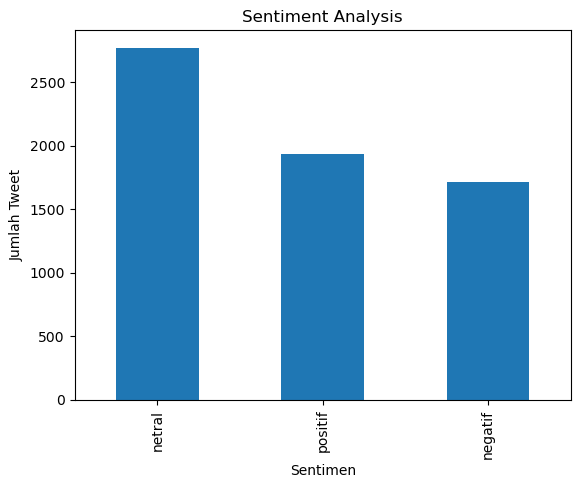

In [5]:
df['sentimen_bert'].value_counts().plot(kind='bar', title='Sentiment Analysis', xlabel='Sentimen', ylabel='Jumlah Tweet')

In [6]:
data_negatif = df[df['sentimen_bert'] == 'negatif']
data_positif = df[df['sentimen_bert'] == 'positif']
data_netral = df[df['sentimen_bert'] == 'netral']

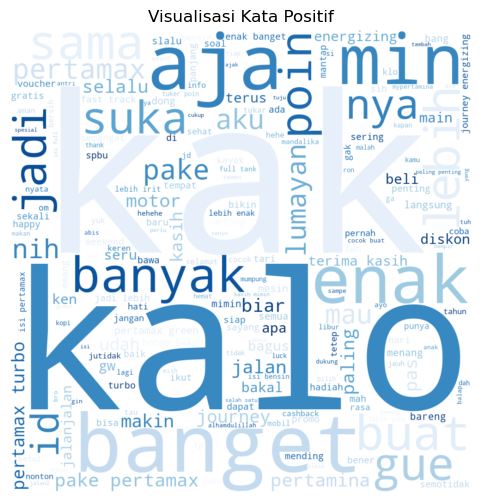

In [7]:
all_text_s1 = ' '.join(word for word in data_positif["Message"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Positif")
plt.margins(x=0, y=0)
plt.show()

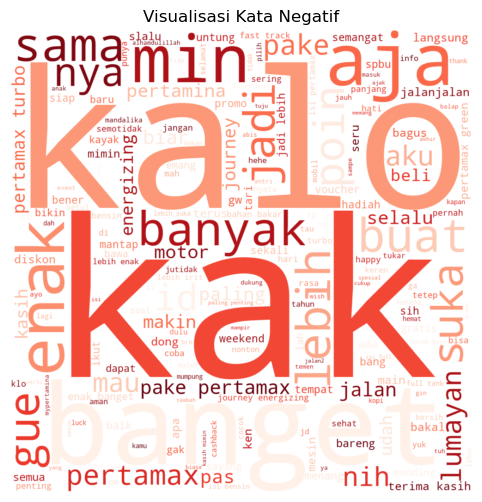

In [8]:
all_text_s2 = ' '.join(word for word in data_negatif["Message"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Negatif")
plt.margins(x=0, y=0)
plt.show()

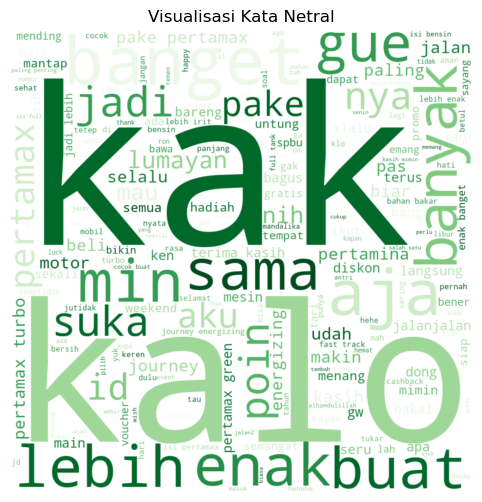

In [9]:
all_text_s3 = ' '.join(word for word in data_netral["Message"])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Netral")
plt.margins(x=0, y=0)
plt.show()

## Spliting Data

In [10]:
# Encode label
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentimen_bert'])

In [11]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Message'].tolist(), 
    df['label'].tolist(), 
    test_size=0.2, 
    random_state=42
)

## Training Data Bert

In [12]:
# Load tokenizer dan model IndoBERT pre-trained untuk sequence classification
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

In [14]:
# Prepare datasets and loaders
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [16]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
# Training loop sederhana
def train_epoch(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Evaluation loop sederhana
def eval_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [19]:
EPOCHS = 3
train_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss = train_epoch(model, train_loader, optimizer)
    val_acc = eval_model(model, val_loader)
    print(f"Train Loss: {train_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

Epoch 1/3


100%|██████████| 321/321 [36:07<00:00,  6.75s/it]


Train Loss: 0.7384 | Validation Accuracy: 0.7531
Epoch 2/3


100%|██████████| 321/321 [34:19<00:00,  6.42s/it]


Train Loss: 0.4506 | Validation Accuracy: 0.7500
Epoch 3/3


100%|██████████| 321/321 [32:40<00:00,  6.11s/it]


Train Loss: 0.2409 | Validation Accuracy: 0.7290


## Evaluation

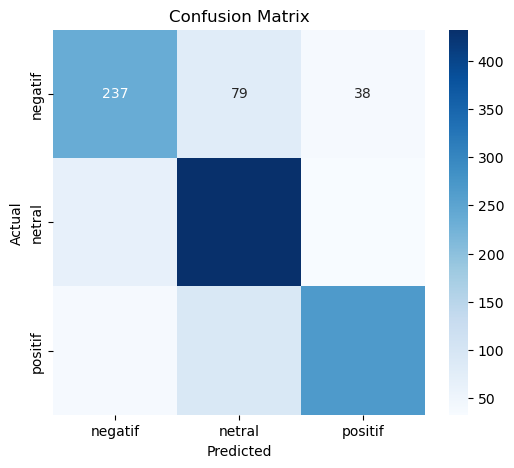

Classification Report:
               precision    recall  f1-score   support

     negatif       0.69      0.67      0.68       354
      netral       0.72      0.81      0.76       532
     positif       0.79      0.67      0.73       398

    accuracy                           0.73      1284
   macro avg       0.73      0.72      0.72      1284
weighted avg       0.73      0.73      0.73      1284



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def eval_model_full_report(model, data_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification report
    report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)

# Setelah training selesai, panggil ini
eval_model_full_report(model, val_loader, label_encoder)